# Pre-processing and modelling
### January 2022

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import seaborn as sns
sns.set_context("talk")

import matplotlib as mpl
mpl.style.use('seaborn')


In [5]:
random_seed = 33

In [6]:
df = pd.read_csv('train_merged.csv', index_col=0, parse_dates=['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4616 entries, 0 to 4615
Columns: 338 entries, Date to spray_last10
dtypes: datetime64[ns](1), float64(327), int64(6), object(4)
memory usage: 11.9+ MB


In [7]:
for c in df.columns: print(c)

Date
Trap
Address
Block
Street
AddressNumberAndStreet
Latitude
Longitude
AddressAccuracy
NumMosquitos
WnvPresent
Week
Month
Year
Distance1
Distance2
AvgSpeed
AvgSpeed_lag1
AvgSpeed_lag10
AvgSpeed_lag2
AvgSpeed_lag3
AvgSpeed_lag4
AvgSpeed_lag5
AvgSpeed_lag6
AvgSpeed_lag7
AvgSpeed_lag8
AvgSpeed_lag9
BCFG
BCFG_lag1
BCFG_lag10
BCFG_lag2
BCFG_lag3
BCFG_lag4
BCFG_lag5
BCFG_lag6
BCFG_lag7
BCFG_lag8
BCFG_lag9
BR
BR_lag1
BR_lag10
BR_lag2
BR_lag3
BR_lag4
BR_lag5
BR_lag6
BR_lag7
BR_lag8
BR_lag9
Cool
Cool_lag1
Cool_lag10
Cool_lag2
Cool_lag3
Cool_lag4
Cool_lag5
Cool_lag6
Cool_lag7
Cool_lag8
Cool_lag9
DZ
DZ_lag1
DZ_lag10
DZ_lag2
DZ_lag3
DZ_lag4
DZ_lag5
DZ_lag6
DZ_lag7
DZ_lag8
DZ_lag9
Daylight
Depart
Depart_lag1
Depart_lag10
Depart_lag2
Depart_lag3
Depart_lag4
Depart_lag5
Depart_lag6
Depart_lag7
Depart_lag8
Depart_lag9
DewPoint
DewPoint_lag1
DewPoint_lag10
DewPoint_lag2
DewPoint_lag3
DewPoint_lag4
DewPoint_lag5
DewPoint_lag6
DewPoint_lag7
DewPoint_lag8
DewPoint_lag9
FG
FG_lag1
FG_lag10
FG_lag2
FG_lag

Thats a lot of columns. I will now drop the columns that will not be used for modelling

In [8]:
drops = ['Date','Trap','Address','Block','Street', 'AddressNumberAndStreet', 'Latitude','Longitude', 'AddressAccuracy', 'NumMosquitos','Week','Month','Year','Distance1','Distance2']
df.drop(drops, axis=1, inplace=True)

In [9]:
y = df['WnvPresent']

X = df.drop('WnvPresent',axis=1)

In [10]:
print(X.shape)
print(y.shape)

(4616, 322)
(4616,)


Now I can split into training and testing sets, making sure that I have the same proportion of positive cases in each. 

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=random_seed)

print('Train positive cases:', sum(y_train)/len(y_train))
print('Test positive cases:',sum(y_test)/len(y_test))

Train positive cases: 0.08342361863488625
Test positive cases: 0.08333333333333333


Now I will calculate the information value of each feature in regards to whether there was a positive case. 

In [12]:
### Function to calculate the Information Value (IV) of each feature
### 


max_bin = 20
force_bin = 3
import pandas.core.algorithms as algos
import scipy.stats.stats as stats


# define a binning function
### this function is for binning and calculating the Weight of Evidence 
### for the target and the Information Value for the feature
### and the In
def mono_bin(Y, X, n = max_bin):    
    ### create new dataframe of series feature and series y
    df1 = pd.DataFrame({"X": X, "Y": Y})
    
    ### check to see if any nulls in feature and seperate nulls out
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    
    
    ### while loop until Spearman correlation coefficient is between [-1,1]
    ### Finding minumum bin size that results in 'abs(r)' of >1???
    
    r = 0
    while np.abs(r) < 1:
        ### Try creation of new dataframe with max or less bin size 'n'
        ### create dataframe with feature, target and binned feature 
        ### create 'd2' group by object on 'Bucket'
        ### calculate Spearman correlation 'r' and p-value from mean of feature and target
        ### If exception reduce bin number by one and try again
        ### Effectively finding the max bin number that can be used 
        ### for calculating WOE
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y,\
                               "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
                             
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    ### If length of d2 is 1 (ie 1 bucket for all of feature) do this
    if len(d2) == 1:
        #print("I am second step ",r, n)
        
        ### force 'n' to 3 and calculate quantiles of feature from (0,0.5,1) 
        ### to be used as bins, if not 3 unique because of heavily skewed data
        ### manually create bin
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
            
        ### Create new dataframe bucketed by manual bins
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    ### Create new dataframe from aggregating the binned dataframe
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    ### add more features to d3 describing the 'events' of the target
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    import traceback
    import re
    
    ### Extract raw traceback from error in one of the two sub functions
    ### assign traceback elemnts to variables
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    
    ###
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    
    ### get column names from df1
    x = df1.dtypes.index
    
    count = -1
    ### Loop through columns
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            ### test if numeric and not a one-hot encoding
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                ###  pass target and feature to 'mono_bin'
                conv = mono_bin(target, df1[i])
                
                ### assign feature name to 'conv'
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                ###  pass target and feature to 'char_bin'
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1

            ### First time run through the loop where count==0,
            ### create new df from current
            if count == 0:
                iv_df = conv
            ### on subsequent loops append rows to bottom of 'iv_df'
            ### of next feature and scoring calcs
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    ### aggregate 'iv_df' taking the maximum ?correlation? score 
    ### for each feature and creating a new summary df with columns 
    ### 'VAR_NAME' & 'IV'
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    ### return detailed df with all computed features
    ### and summary of only max values and feature names
    return(iv_df,iv)

In [13]:
iv_df, iv = data_vars(X_train,y_train)

AvgSpeed
0    0.249057
1   -0.314808
dtype: float64
AvgSpeed_lag1
0   -0.088193
1    0.082153
dtype: float64
AvgSpeed_lag10
0    0.133993
1   -0.150864
dtype: float64
AvgSpeed_lag2
0   -0.043280
1    0.041774
dtype: float64
AvgSpeed_lag3
0    0.265087
1    0.070031
2   -0.134880
3   -0.269356
dtype: float64
AvgSpeed_lag4
0   -0.021444
1    0.021068
dtype: float64
AvgSpeed_lag5
0    0.277663
1   -0.362145
dtype: float64
AvgSpeed_lag6
0    0.268846
1    0.144074
2   -0.574555
dtype: float64
AvgSpeed_lag7
0    0.159117
1   -0.183503
dtype: float64
AvgSpeed_lag8
0    0.207587
1    0.125036
2   -0.427077
dtype: float64
AvgSpeed_lag9
0    0.476556
1    0.068842
2   -0.134880
3   -0.697732
dtype: float64
BCFG
BCFG_lag1
BCFG_lag10
0    0.000296
1        -inf
dtype: float64
BCFG_lag2
BCFG_lag3
0    0.000591
1        -inf
dtype: float64
BCFG_lag4
BCFG_lag5
BCFG_lag6
BCFG_lag7


C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0    0.0
1    NaN
dtype: float64
BCFG_lag8
0    0.0
1    NaN
dtype: float64
BCFG_lag9
BR
0   -0.007442
1    0.838569
dtype: float64
BR_lag1
0   -0.008952
1    0.787276
dtype: float64
BR_lag10
0   -0.020092
1    1.431633
dtype: float64
BR_lag2
0   -0.003860
1    0.499594
dtype: float64
BR_lag3
0   -0.009250
1    0.828098
dtype: float64
BR_lag4
0   -0.011364
1    0.856269
dtype: float64
BR_lag5
0   -0.006252
1    0.647514
dtype: float64
BR_lag6
0   -0.007442
1    0.838569
dtype: float64
BR_lag7
0   -0.011034
1    1.115780
dtype: float64
BR_lag8
0   -0.015230
1    1.480423
dtype: float64
BR_lag9
0   -0.003266
1    0.404284
dtype: float64
Cool
0   -0.278883
1    0.226301
dtype: float64
Cool_lag1
0   -1.067905
1   -0.324120
2    0.140755
3    0.648495
dtype: float64
Cool_lag10
0   -0.611015
1    0.200393
2    0.234206
dtype: float64
Cool_lag2
0   -0.727569
1   -0.233084
2    0.278878
3    0.376885
dtype: float64
Cool_lag3
0   -0.143429
1    0.128230
dtype: float64
Cool_lag4
0   -0.142845
1 

0    0.319099
1    0.004128
2   -0.442537
dtype: float64
SN
SN_lag1
SN_lag10
SN_lag2
SN_lag3
SN_lag4
SN_lag5
SN_lag6
SN_lag7
SN_lag8
SN_lag9
SQ
SQ_lag1
SQ_lag10
SQ_lag2
SQ_lag3
0    0.0
1    NaN
dtype: float64
SQ_lag4
SQ_lag5
SQ_lag6
SQ_lag7
SQ_lag8
SQ_lag9
0    0.0
1    NaN
dtype: float64
SeaLevel
0   -0.014844
1    0.014678
dtype: float64
SeaLevel_lag1
0    0.075515
1   -0.080588
dtype: float64
SeaLevel_lag10
0    0.041774
1   -0.043280
dtype: float64
SeaLevel_lag2
0   -0.137489
1   -0.123545
2    0.225395
dtype: float64
SeaLevel_lag3
0   -0.807612
1    0.021808
2    0.179711
3    0.322139
dtype: float64
SeaLevel_lag4
0   -0.474108
1   -0.017253
2    0.351541
dtype: float64
SeaLevel_lag5
0   -0.050649
1    0.048597
dtype: float64
SeaLevel_lag6
0    0.048597
1   -0.050649
dtype: float64
SeaLevel_lag7
0   -0.049737
1    0.048319
dtype: float64
SeaLevel_lag8
0   -0.183503
1    0.159117
dtype: float64
SeaLevel_lag9
0   -0.150864
1    0.133993
dtype: float64
SnowFall
0    0.0
1    NaN
dty

In [14]:
iv.sort_values('IV',ascending=False)

,VAR_NAME,IV
55,Daylight,0.577263
68,DewPoint_lag1,0.420752
287,Tmin_lag1,0.392661
34,Cool_lag1,0.347342
265,Tavg_lag1,0.342707
...,...,...
202,SQ_lag3,0.000000
201,SQ_lag2,0.000000
200,SQ_lag10,0.000000
199,SQ_lag1,0.000000


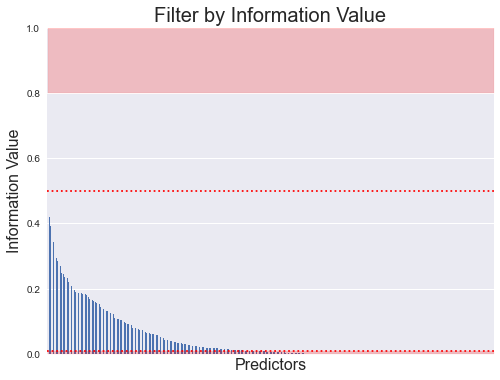

In [15]:
iv = iv.sort_values('IV',ascending=False)
iv.plot(x='VAR_NAME',y='IV',kind='bar',figsize=(8,6))
plt.xlabel('Predictors',fontsize=16)
plt.ylabel('Information Value',fontsize=16)
plt.axhline(0.01,color = 'red',linestyle=':')
plt.axhline(0.8,color = 'red',linestyle=':')

plt.fill_between(x=[0,len(iv)],y1=1,y2=0.8,color='red',alpha=0.2)
plt.fill_between(x=[0,len(iv)],y1=0,y2=0.01,color='red',alpha=0.2)
plt.ylim((0,1))


plt.xticks([])

plt.title('Filter by Information Value',fontsize=20)

plt.legend().remove()
plt.show()

In [16]:
feats = iv[(iv.IV>0.01) & (iv.IV<0.8)]['VAR_NAME'].to_list()
print(feats[:10])
print(len(feats))

['DewPoint_lag1', 'Tmin_lag1', 'Cool_lag1', 'Tavg_lag1', 'Heat_lag8', 'DewPoint_lag8', 'Tmin_lag8', 'Tavg_lag8', 'Cool_lag8', 'StnPressure_lag3']
141


After filtering out features that have a IV >.8 and an IV<0.01 there are 153 predictive features remaining. 

In [17]:
X_train = X_train[feats]
X_test = X_test[feats]
print(X_train.shape)
print(X_test.shape)

(3692, 141)
(924, 141)


Now I will standardize the features.  I think I will need to use a non-linear model, but I will attempt a logistic regression model anyway and evaluate the result

In [18]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)


Note, X's are now numpy arrays

I am curious to see the PCA components and the % variance explained

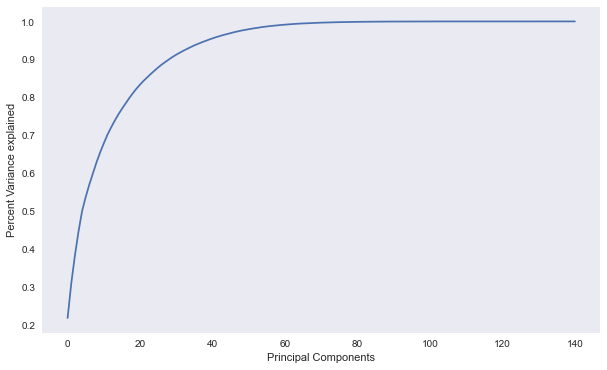

In [19]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)
X_pca = pca.transform(X_train)
                      
plt.subplots(figsize=(10, 6))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Percent Variance explained')
plt.xlabel('Principal Components')
plt.grid(axis='both')
plt.show()

The first ~50 principal components explains ~95% of the variance.  I may need to revisit my features and whittle them down a bit more. 

# Modeling!
First a couple of functions for evaluating models and storing results

In [20]:
def Model_Eval(estimator,X_train,X_test,y_train,y_test):
    from sklearn.metrics import plot_confusion_matrix,precision_score,\
                                recall_score, plot_roc_curve
    import matplotlib.pyplot as plt
    
    fig,ax = plt.subplots(figsize=(5,5))
    plot_roc_curve(estimator,X_train,y_train,ax=ax,name='Train')
    plot_roc_curve(estimator,X_test,y_test,ax=ax,name='Test')
    plt.title('ROC curve')
    plt.show()

    fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
    plot_confusion_matrix(estimator,X_train,y_train,values_format='.4g',ax=ax[0],cmap='Blues')
    plot_confusion_matrix(estimator,X_test,y_test,values_format='.4g',ax=ax[1],cmap='Oranges')
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    plt.show()

    ### Training
    print('Train Precision {:.3f}'.format(precision_score(\
                              y_train,estimator.predict(X_train))))
    print('Train Recall    {:.3f}'.format(recall_score(\
                               y_train,estimator.predict(X_train))))
    print()
    ### Testing
    print('Test Precision  {:.3f}'.format(precision_score(\
                              y_test,estimator.predict(X_test))))
    print('Test Recall     {:.3f}'.format(recall_score(\
                               y_test,estimator.predict(X_test))))

In [21]:
def agg_score_df(scores_df,estimator,name,X_train,X_test,y_train,y_test,\
                 df_cols=['Model','Train_AUC','Test_AUC','Train_prec',\
                          'Train_recal','Test_prec','Test_recal']):
    """
    """
    
    scores=[]
    scores.append(name)
    scores.append(roc_auc_score(y_train,estimator.predict_proba(X_train)[:,1]))
    scores.append(roc_auc_score(y_test,estimator.predict_proba(X_test)[:,1]))
    scores.append(precision_score(y_train,estimator.predict(X_train)))
    scores.append(recall_score(y_train,estimator.predict(X_train)))
    scores.append(precision_score(y_test,estimator.predict(X_test)))
    scores.append(recall_score(y_test,estimator.predict(X_test)))
    
    scores = np.array(scores).reshape(1,7)
    scores_df = pd.concat([scores_df,pd.DataFrame(scores,columns=df_cols)])

    return scores_df.reset_index(drop=True)

In [22]:
### initialize dataframe for recording model performance
df_cols = ['Model','Train_AUC','Test_AUC','Train_prec','Train_recal','Test_prec','Test_recal']
scores_df=pd.DataFrame(columns=df_cols)

Now I will try a logistic regression and see how well it does on the hold out set. 

In [23]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [24]:
y_test.shape

(924,)

In [25]:
X_test.shape

(924, 141)

## Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import plot_roc_curve, recall_score, precision_score, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score

logreg = LogisticRegression(max_iter=300)

params={'C':np.linspace(0,1,1000), 'class_weight':[None,'balanced']}

rand_search = RandomizedSearchCV(logreg, param_distributions=params, random_state=random_seed,
                                 scoring='recall', cv=5, n_iter=20, n_jobs=-1)
rand_search.fit(X_train,y_train)

print(rand_search.best_params_)
print('CV test AUC scores:',rand_search.best_score_)



#fig,ax = plt.subplots(figsize=(5,5))
#plot_roc_curve(logreg,X_train,y_train,ax=ax,name='Train')
#plot_roc_curve(logreg,X_test,y_test,ax=ax,name='Test')
#plt.show()

{'class_weight': 'balanced', 'C': 0.028028028028028028}
CV test AUC scores: 0.8116869381279745


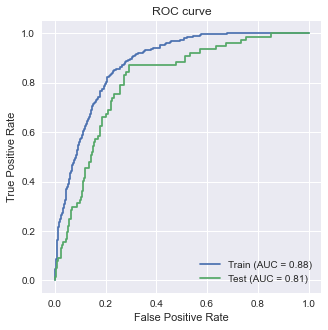

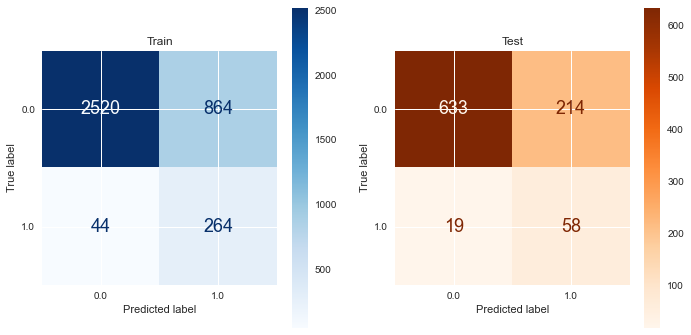

Train Precision 0.234
Train Recall    0.857

Test Precision  0.213
Test Recall     0.753


In [27]:
Model_Eval(rand_search,X_train,X_test,y_train,y_test)

That is a pretty good result, with a relatively good AUC and not much overfitting to the training set.  But the recall is awful. I might need to oversample the positive cases.

In [28]:
coefs = pd.DataFrame({'feature':feats,'coef':list(rand_search.best_estimator_.coef_[0])})
coefs['abs'] = abs(coefs.coef)
coefs.sort_values('abs',ascending=False)

,feature,coef,abs
11,ResultSpeed_lag8,-0.456063,0.456063
65,Tmax_lag7,-0.444058,0.444058
56,Heat_lag1,0.439631,0.439631
109,ResultDir_lag3,0.419947,0.419947
79,ResultSpeed_lag1,-0.402974,0.402974
...,...,...,...
115,DewPoint_lag9,-0.004999,0.004999
88,Depart_lag10,0.004330,0.004330
57,Heat_lag4,0.003855,0.003855
95,Tmin_lag3,-0.002290,0.002290


In [29]:
scores_df = agg_score_df(scores_df,rand_search.best_estimator_,'LogReg',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,LogReg,0.8779109483896719,0.8062374461429951,0.23404255319148937,0.8571428571428571,0.21323529411764705,0.7532467532467533


Now moving on to nonlinear models. 
## Random Forest

In [30]:
### Start with a random forest

from sklearn.ensemble import RandomForestClassifier


params={'max_features':[.8,.5,.3,'sqrt','log2'],
       'min_samples_leaf':list(range(5,50)),
        'n_estimators':list(range(50,300,20)),
       'max_depth':list(range(5,20)),
       'class_weight':[None,'balanced']}

rfc = RandomForestClassifier(random_state = random_seed, n_jobs=-1)
rand_search = RandomizedSearchCV(rfc, param_distributions = params, cv=3,
                                 n_iter=10, scoring='recall', random_state = random_seed)

rand_search.fit(X_train,y_train)



#fig,ax = plt.subplots(figsize=(5,5))
#plot_roc_curve(rand_search,X_train,y_train,ax=ax,name='Train')
#plot_roc_curve(rand_search,X_test,y_test,ax=ax,name='Test')
#plt.show()
#
print('Best params:', rand_search.best_params_)
print('CV test AUC scores:',rand_search.best_score_)
#
#
#print('Training Metrics')
#print(f'Precision: {precision_score(y_train,rand_search.predict(X_train)):.3f}')
#print(f'Recall:    {recall_score(y_train,rand_search.predict(X_train)):.3f}')
#print()
#print('Testing Metrics')
#print(f'Precision: {precision_score(y_test,rand_search.predict(X_test)):.3f}')
#print(f'Recall:    {recall_score(y_test,rand_search.predict(X_test)):.3f}')

Best params: {'n_estimators': 110, 'min_samples_leaf': 25, 'max_features': 'log2', 'max_depth': 5, 'class_weight': 'balanced'}
CV test AUC scores: 0.746843073799099


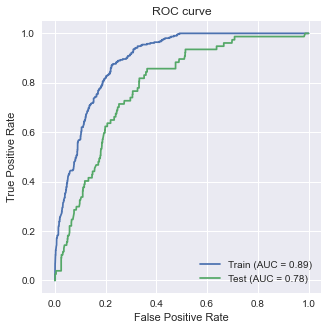

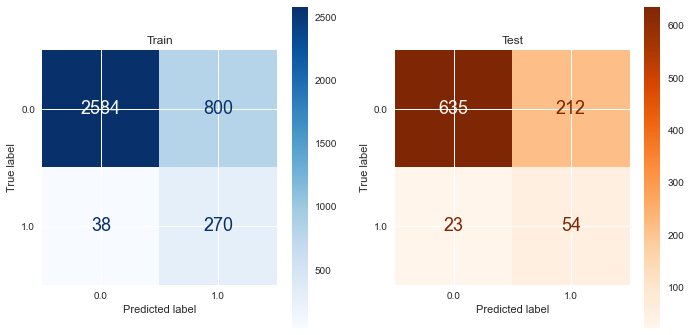

Train Precision 0.252
Train Recall    0.877

Test Precision  0.203
Test Recall     0.701


In [31]:
Model_Eval(rand_search,X_train,X_test,y_train,y_test)

In [32]:
scores_df = agg_score_df(scores_df,rand_search.best_estimator_,'RandForest',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,LogReg,0.8779109483896719,0.8062374461429951,0.23404255319148937,0.8571428571428571,0.21323529411764705,0.7532467532467533
1,RandForest,0.8902445810690491,0.7828776890170042,0.2523364485981308,0.8766233766233766,0.20300751879699247,0.7012987012987013


## XGBoost

In [33]:
import xgboost

In [34]:
eval_set=[(X_train,y_train),(X_test,y_test)]
eval_metric = ['auc']


model = xgboost.XGBClassifier(n_estimators=100, random_state=random_seed)

model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

print()
from sklearn.metrics import roc_auc_score
print('Test AUC score: ',roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print('Test recall: ',recall_score(y_test, model.predict(X_test)))

[0]	validation_0-auc:0.81660	validation_1-auc:0.65449
[1]	validation_0-auc:0.89351	validation_1-auc:0.74659
[2]	validation_0-auc:0.89769	validation_1-auc:0.75135
[3]	validation_0-auc:0.91460	validation_1-auc:0.77933
[4]	validation_0-auc:0.92695	validation_1-auc:0.80656
[5]	validation_0-auc:0.93511	validation_1-auc:0.81176
[6]	validation_0-auc:0.94012	validation_1-auc:0.80920
[7]	validation_0-auc:0.94361	validation_1-auc:0.80882
[8]	validation_0-auc:0.94568	validation_1-auc:0.80996
[9]	validation_0-auc:0.94704	validation_1-auc:0.80792


C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-auc:0.94957	validation_1-auc:0.80241
[11]	validation_0-auc:0.95080	validation_1-auc:0.80445
[12]	validation_0-auc:0.95444	validation_1-auc:0.80548
[13]	validation_0-auc:0.95642	validation_1-auc:0.80536
[14]	validation_0-auc:0.95871	validation_1-auc:0.80436
[15]	validation_0-auc:0.96062	validation_1-auc:0.80407
[16]	validation_0-auc:0.96280	validation_1-auc:0.80181
[17]	validation_0-auc:0.96409	validation_1-auc:0.80283
[18]	validation_0-auc:0.96493	validation_1-auc:0.80081
[19]	validation_0-auc:0.96497	validation_1-auc:0.80125
[20]	validation_0-auc:0.96528	validation_1-auc:0.80130
[21]	validation_0-auc:0.96718	validation_1-auc:0.79738
[22]	validation_0-auc:0.97096	validation_1-auc:0.79289
[23]	validation_0-auc:0.97298	validation_1-auc:0.78829
[24]	validation_0-auc:0.97432	validation_1-auc:0.78777
[25]	validation_0-auc:0.97783	validation_1-auc:0.78900
[26]	validation_0-auc:0.97956	validation_1-auc:0.78794
[27]	validation_0-auc:0.98230	validation_1-auc:0.78700
[28]	valid

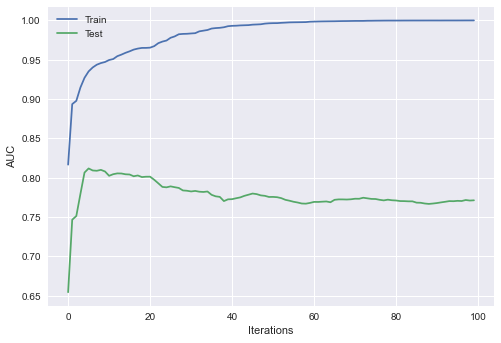

In [35]:
plt.plot(np.arange(len(model.evals_result_['validation_0']['auc'])),\
        model.evals_result_['validation_0']['auc'])
plt.plot(np.arange(len(model.evals_result_['validation_1']['auc'])),\
        model.evals_result_['validation_1']['auc'])

plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.legend(labels=['Train','Test'])


plt.show()

The default XGboost model over fits.  I need a stopping criteria

In [38]:
from sklearn.metrics import recall_score

In [39]:
model = xgboost.XGBClassifier(n_estimators = 100, random_state=random_seed, max_depth=6)
model.fit(X_train,y_train, eval_metric=eval_metric, eval_set=eval_set,verbose=True,
        early_stopping_rounds=3)
print()
print('Test AUC score: ',roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
print('Test recall: ',recall_score(y_test,model.predict(X_test)))                              

[0]	validation_0-auc:0.81660	validation_1-auc:0.65449
[1]	validation_0-auc:0.89351	validation_1-auc:0.74659
[2]	validation_0-auc:0.89769	validation_1-auc:0.75135
[3]	validation_0-auc:0.91460	validation_1-auc:0.77933
[4]	validation_0-auc:0.92695	validation_1-auc:0.80656
[5]	validation_0-auc:0.93511	validation_1-auc:0.81176
[6]	validation_0-auc:0.94012	validation_1-auc:0.80920
[7]	validation_0-auc:0.94361	validation_1-auc:0.80882

Test AUC score:  0.8117649764639139
Test recall:  0.06493506493506493


C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


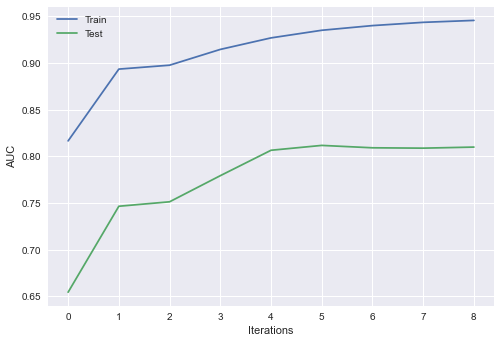

In [40]:
plt.plot(np.arange(len(model.evals_result_['validation_0']['auc'])),\
        model.evals_result_['validation_0']['auc'])
plt.plot(np.arange(len(model.evals_result_['validation_1']['auc'])),\
        model.evals_result_['validation_1']['auc'])

plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.legend(labels=['Train','Test'])


plt.show()


Adding the stopping criteria resulted in only 11 iterations/trees 

In [41]:
model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=33,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

In [42]:
### perform cross validation to check generalizeability
from sklearn.model_selection import cross_validate
k=3
n = 11

model = xgboost.XGBClassifier(n_estimators = n, random_state = random_seed, eval_metric=['auc'])


scores = cross_validate(model, X_train, y_train, cv=k, 
                       scoring = ['recall','roc_auc','precision','roc_auc_ovo_weighted'],
                       return_train_score=True)
pd.DataFrame(scores)

C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklea

,fit_time,score_time,test_recall,train_recall,test_roc_auc,train_roc_auc,test_precision,train_precision,test_roc_auc_ovo_weighted,train_roc_auc_ovo_weighted
0,0.120997,0.011000,0.213592,0.375610,0.806002,0.968883,0.523810,0.905882,0.806002,0.968883
1,0.126002,0.010999,0.194175,0.385366,0.828982,0.965899,0.444444,0.887640,0.828982,0.965899
2,0.117999,0.012000,0.166667,0.339806,0.828453,0.964778,0.459459,0.897436,0.828453,0.964778


The test AUC scores range from .82 to .84.  That is pretty good for the cross validation.

Finally a look at tuning the learning rate.

In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [44]:
params = {'learning_rate':np.linspace(.001,.5,100)}

model = xgboost.XGBClassifier(random_state=random_seed, eval_metric=['auc'], early_stopping_rounds=3)

xgb_grid = RandomizedSearchCV(model,param_distributions=params, cv=3, scoring=['roc_auc','recall','precision'],
                       refit = 'roc_auc', return_train_score=True)
xgb_grid.fit(X_train,y_train)

print()
print('Best params:',xgb_grid.best_params_)

C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:17:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Best params: {'learning_rate': 0.06148484848484849}


In [45]:
pd.DataFrame(xgb_grid.cv_results_)[['params','mean_test_recall','mean_test_precision','mean_test_roc_auc']]

,params,mean_test_recall,mean_test_precision,mean_test_roc_auc
0,{'learning_rate': 0.2631010101010101},0.246780,0.362581,0.800158
1,{'learning_rate': 0.33870707070707073},0.263024,0.367102,0.798229
2,{'learning_rate': 0.1018080808080808},0.214322,0.435859,0.813965
3,{'learning_rate': 0.4546363636363636},0.253252,0.346801,0.789106
4,{'learning_rate': 0.3185454545454545},0.256520,0.355361,0.795039
5,{'learning_rate': 0.36894949494949497},0.259820,0.345853,0.793282
6,{'learning_rate': 0.32862626262626266},0.259756,0.353161,0.796529
7,{'learning_rate': 0.34374747474747475},0.246811,0.345010,0.792891
8,{'learning_rate': 0.25302020202020203},0.250048,0.341583,0.800446
9,{'learning_rate': 0.06148484848484849},0.198109,0.476923,0.821468


Tuning the learning rate didn't increase the test AUC

In [46]:
### Create weighting for positive cases 

from collections import Counter
counter = Counter(y_train)
print(counter)
w8 = counter[0]/counter[1]
print(w8)

Counter({0.0: 3384, 1.0: 308})
10.987012987012987


In [47]:
model = xgboost.XGBClassifier(n_estimators = 100, random_state=random_seed, scale_pos_weight = w8)
model.fit(X_train,y_train, eval_metric=eval_metric, eval_set=eval_set,verbose=True,early_stopping_rounds=3)
print()
print('Test AUC score: ',roc_auc_score(y_test,model.predict_proba(X_test)[:,1]))
print('Test recall: ',recall_score(y_test,model.predict(X_test)))             

[0]	validation_0-auc:0.90574	validation_1-auc:0.78196
[1]	validation_0-auc:0.92229	validation_1-auc:0.77351
[2]	validation_0-auc:0.92785	validation_1-auc:0.79501
[3]	validation_0-auc:0.93139	validation_1-auc:0.78614
[4]	validation_0-auc:0.93401	validation_1-auc:0.78956


C:\Users\blain\Anaconda3\envs\ml_env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



Test AUC score:  0.7950137229948327
Test recall:  0.6753246753246753


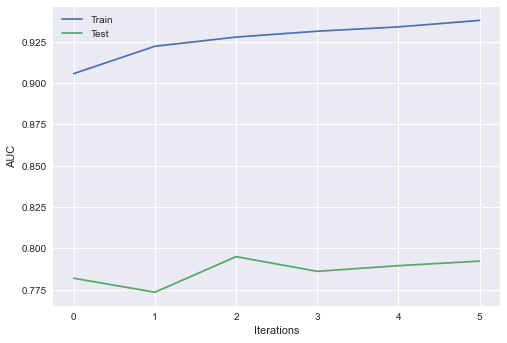

In [48]:
plt.plot(np.arange(len(model.evals_result_['validation_0']['auc'])),\
        model.evals_result_['validation_0']['auc'])
plt.plot(np.arange(len(model.evals_result_['validation_1']['auc'])),\
        model.evals_result_['validation_1']['auc'])

plt.ylabel('AUC')
plt.xlabel('Iterations')
plt.legend(labels=['Train','Test'])


plt.show()


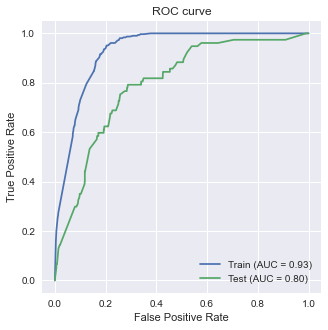

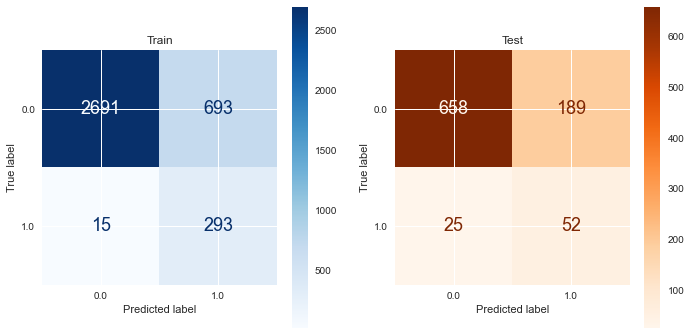

Train Precision 0.297
Train Recall    0.951

Test Precision  0.216
Test Recall     0.675


In [49]:
Model_Eval(model,X_train,X_test,y_train,y_test)

In [50]:
scores_df = agg_score_df(scores_df,model,'XGBoost',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,LogReg,0.8779109483896719,0.8062374461429951,0.23404255319148937,0.8571428571428571,0.21323529411764705,0.7532467532467533
1,RandForest,0.8902445810690491,0.7828776890170042,0.2523364485981308,0.8766233766233766,0.20300751879699247,0.7012987012987013
2,XGBoost,0.9278460900801326,0.7950137229948327,0.2971602434077079,0.9512987012987013,0.2157676348547718,0.6753246753246753


In [51]:
from sklearn.metrics import precision_score

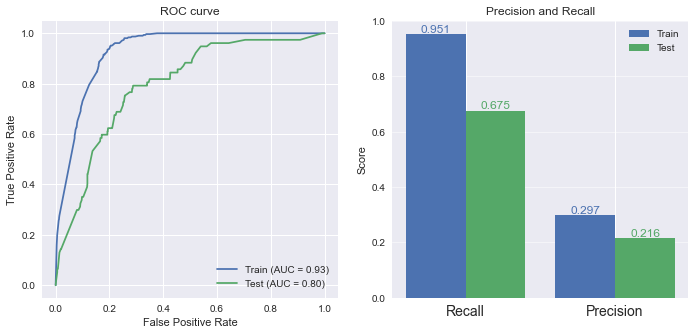

In [52]:
from sklearn.metrics import plot_roc_curve

fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
plot_roc_curve(model,X_train,y_train,ax=ax[0],name='Train')
plot_roc_curve(model,X_test,y_test,ax=ax[0],name='Test')
ax[0].set_title('ROC curve')


#plt.show()
trainnn = [recall_score(y_train,model.predict(X_train)),\
           precision_score(y_train,model.predict(X_train))]
testtt = [recall_score(y_test,model.predict(X_test)),\
          precision_score(y_test,model.predict(X_test))]

ind = np.arange(2)
width = .4


ax[1].bar(ind-width/2,trainnn,width,label='Train')
ax[1].bar(ind+width/2,testtt,width,label='Test')


ax[1].set_title('Precision and Recall')
ax[1].set_xticks(ind)
ax[1].set_xticklabels(['Recall','Precision'],fontsize=14)
ax[1].set_ylabel('Score')
ax[1].set_ylim((0,1))

ax[1].legend(loc='upper right')
ax[1].grid(axis='y',alpha=.5)

for bar in ax[1].patches:
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  # Format the text with commas to separate thousands. You can do
  # any type of formatting here though.
  text = '{:.3f}'.format(bar_value)
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax[1].text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)


plt.show()

## Support Vector Classifier

In [53]:
from sklearn.svm import SVC

In [54]:
params={'C':np.linspace(.1,1,50),
        'kernel':['rbf','linear'],
        'gamma':['scale','auto'],
       'class_weight':[None,'balanced']}

svc = SVC(random_state=random_seed, probability=True)

rand_svc = RandomizedSearchCV(svc, param_distributions = params, cv=3,
                              n_jobs=-1, scoring='roc_auc', random_state=random_seed,
                             )

rand_svc.fit(X_train,y_train)

print('Best Params: ',rand_svc.best_params_)
print('Best Score; ',rand_svc.best_score_)

Best Params:  {'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 0.2469387755102041}
Best Score;  0.8228697076847679


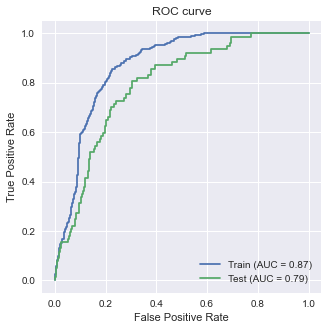

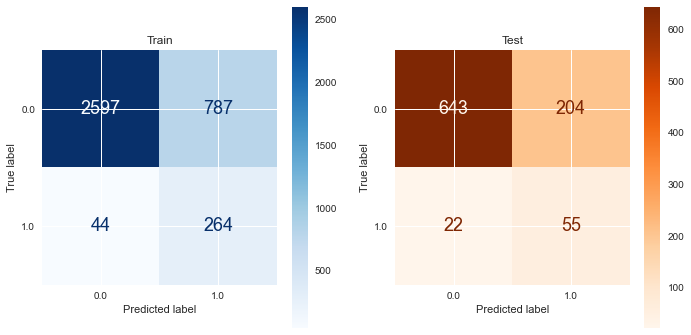

Train Precision 0.251
Train Recall    0.857

Test Precision  0.212
Test Recall     0.714


In [55]:
Model_Eval(rand_svc.best_estimator_,X_train,X_test,y_train,y_test)

In [56]:
scores_df = agg_score_df(scores_df,rand_svc.best_estimator_,'SVC',X_train,X_test,y_train,y_test)
scores_df.tail()

,Model,Train_AUC,Test_AUC,Train_prec,Train_recal,Test_prec,Test_recal
0,LogReg,0.8779109483896719,0.8062374461429951,0.23404255319148937,0.8571428571428571,0.21323529411764705,0.7532467532467533
1,RandForest,0.8902445810690491,0.7828776890170042,0.2523364485981308,0.8766233766233766,0.20300751879699247,0.7012987012987013
2,XGBoost,0.9278460900801326,0.7950137229948327,0.2971602434077079,0.9512987012987013,0.2157676348547718,0.6753246753246753
3,SVC,0.8697595253446317,0.7934037627071866,0.25118934348239774,0.8571428571428571,0.21235521235521235,0.7142857142857143


# Try oversampling with two of the above and see if there is any improvement.

In [57]:
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


ModuleNotFoundError: No module named 'imblearn'

In [ ]:
### distribution for SMOTE sampling strategy
### a value of 1 resamples the data to 50:50

minority_range = np.linspace(.1,.5,100)
minority_range = minority_range/(1-minority_range)
minority_range

In [ ]:
### First try logistic regression
steps = [('smote',SMOTE(random_state = random_seed)),
         ('logreg',LogisticRegression(max_iter=500))]

pipe = Pipeline(steps)

params = {'smote__sampling_strategy':minority_range,
         'logreg__C':np.linspace(.2,1,100)}

rand_pipe = RandomizedSearchCV(pipe, param_distributions=params, n_jobs=-1, n_iter=10,
                              scoring='roc_auc', cv=5)
rand_pipe.fit(X_train,y_train)

print(rand_pipe.best_params_)
print('Best score',rand_pipe.best_score_)

In [ ]:
Model_Eval(rand_pipe.best_estimator_,X_train,X_test,y_train,y_test)

In [ ]:
scores_df = agg_score_df(scores_df,rand_pipe.best_estimator_,'LogReg_SMOTE',X_train,X_test,y_train,y_test)
scores_df.tail()

### XGBoost classifier with SMOTE

In [ ]:
### XGBoost Classifier
steps = [('smote',SMOTE(random_state = random_seed)),
         ('xgb',xgboost.XGBClassifier(learning_rate=.1))]

pipe = Pipeline(steps)

params = {'smote__sampling_strategy':minority_range}

rand_pipe = RandomizedSearchCV(pipe, param_distributions=params, n_jobs=-1, n_iter=10,
                              scoring='roc_auc', cv=5)

fit_params = {'xgb__eval_metric':eval_metric, 'xgb__eval_set':eval_set,'xgb__early_stopping_rounds':3}

rand_pipe.fit(X_train,y_train, **fit_params)

print(rand_pipe.best_params_)
print('Best score',rand_pipe.best_score_)

In [ ]:
Model_Eval(rand_pipe.best_estimator_,X_train,X_test,y_train,y_test)

In [ ]:
scores_df = agg_score_df(scores_df, rand_pipe.best_estimator_,'XGB_SMOTE',X_train,X_test,y_train,y_test)
scores_df.tail()

### RandomForest with SMOTE


In [ ]:
### XGBoost Classifier
steps = [('smote',SMOTE(random_state = random_seed)),
         ('rfc',RandomForestClassifier(random_state=random_seed))]

pipe = Pipeline(steps)

params = {'smote__sampling_strategy':minority_range,
          'rfc__max_features':[.8,.5,.3,'sqrt','log2'],
          'rfc__min_samples_leaf':list(range(5,50)),
          'rfc__n_estimators':list(range(50,300,10)),
          'rfc__max_depth':list(range(5,20))}

rand_pipe = RandomizedSearchCV(pipe, param_distributions=params, n_jobs=-1, n_iter=20,
                              scoring='roc_auc', cv=5)

rand_pipe.fit(X_train,y_train)

print(rand_pipe.best_params_)
print('Best score',rand_pipe.best_score_)

In [ ]:
Model_Eval(rand_pipe.best_estimator_, X_train,X_test,y_train,y_test)


In [ ]:
scores_df = agg_score_df(scores_df, rand_pipe.best_estimator_,'RF_SMOTE',X_train,X_test,y_train,y_test)
scores_df.tail()

## Model Evaluation

In [ ]:
### Sort and change column types to numeric
scores_df = scores_df.drop_duplicates()


for c in scores_df.columns:
    if c =='Model': continue
    scores_df[c] = pd.to_numeric(scores_df[c])
scores_df = scores_df.sort_values(by='Test_AUC',ascending=False)

In [ ]:
### Bar plot of Test AUC and Test Recall

ind = np.arange(scores_df.shape[0])
width = .27

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(ind-width,scores_df.Test_AUC,width,label='Test AUC')
ax.bar(ind,scores_df.Test_recal,width,label='Test recall')
ax.bar(ind+width,scores_df.Test_prec,width,label='Test precision')

ax.set_ylabel('Scores',fontsize=16)

ax.set_ylim(0,1)

ax.set_xticks(ind)
ax.set_xticklabels(scores_df.Model,rotation=75,fontsize=14)

ax.set_title('Model Metric Scores',fontsize=20)
ax.legend(fontsize=12)
ax.grid(axis='y',alpha=.5)

plt.show()


In [ ]:
import shap

In [ ]:
explainer = shap.Explainer(model, feature_names = feats)
shap_values = explainer(X_train)
#shap.plots.waterfall(shap_values[0])
shap_values.shape

In [ ]:
shap.plots.waterfall(shap_values[0,:])

In [ ]:
shap.plots.waterfall(shap_values[10,:])

In [ ]:
shap.plots.beeswarm(shap_values)